In [2]:
import jieba
import numpy as np
import sys
import matplotlib.pyplot as plt
import tensorflow as tf

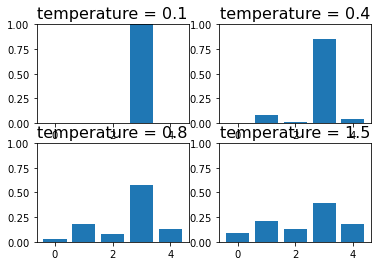

In [3]:
def sample(p, temperature=1.0):  # 定义采样策略
    distribution = np.log(p) / temperature
    distribution = np.exp(distribution)
    return distribution / np.sum(distribution)

p = [0.05, 0.2, 0.1, 0.5, 0.15]

for i, t in zip(range(4), [0.1, 0.4, 0.8, 1.5]):
    plt.subplot(2, 2, i+1)
    plt.bar(np.arange(5), sample(p, t))
    plt.title("temperature = %s" %t, size=16)
    plt.ylim(0,1)

In [4]:
# 导入数据：白夜行文本
file_path = r"D:\machine learning\text generation\data\白夜行.txt"

In [5]:
# 分词，构建词典
whole = open(file_path, encoding='utf-8').read()
all_words = list(jieba.cut(whole, cut_all=False))  # jieba分词
words = sorted(list(set(all_words))) # 不重复词
# word_indices = dict((word, index) for word, index in enumerate(words))
word_indices = dict((word, words.index(word)) for word in words)
print("字典单词，字典数量", len(all_words),len(word_indices.values()))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\liu\AppData\Local\Temp\jieba.cache
Loading model cost 0.643 seconds.
Prefix dict has been built successfully.


字典单词，字典数量 235834 16412


In [6]:
# 构建序列长度, 30
maxlen = 30
sentences = []
next_word = []

for i in range(0, len(all_words) - maxlen):
    sentences.append(all_words[i: i + maxlen]) # 句子
    next_word.append(all_words[i + maxlen])  # 句子对应的单词
print('提取的句子总数:', len(sentences))

提取的句子总数: 235804


In [7]:
# 构建词向量
# x: [sentence, seq_length],235804, 30
x = np.zeros((len(sentences), maxlen), dtype='float32') # Embedding的输入是2维张量（句子数，序列长度）
y = np.zeros((len(sentences)), dtype='float32') # (235804,)
for i, sentence in enumerate(sentences):
    for t, word in enumerate(sentence):
        x[i, t] = word_indices[word]
    y[i] = word_indices[next_word[i]]
print(x.shape,y.shape)

(235804, 30) (235804,)


In [8]:
print(np.round((sys.getsizeof(x) / 1024 / 1024 / 1024), 2), "GB") 

0.03 GB


In [9]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

In [10]:
main_input = layers.Input(shape=(maxlen, ), dtype='float32') 
model_1 = layers.Embedding(len(words), 128, input_length=maxlen)(main_input)
model_1 = layers.Bidirectional(layers.GRU(256, return_sequences=True))(model_1)
model_1 = layers.Bidirectional(layers.GRU(128))(model_1)
output = layers.Dense(len(words), activation='softmax')(model_1)  
model = keras.models.Model(main_input, output)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 128)           2100736   
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 512)           592896    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               493056    
_________________________________________________________________
dense (Dense)                (None, 16412)             4217884   
Total params: 7,404,572
Trainable params: 7,404,572
Non-trainable params: 0
_________________________________________________________________


In [13]:
optimizer = tf.keras.optimizers.RMSprop(lr=3e-3)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

In [14]:
model.fit(x, y, epochs=64, batch_size=1024, verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 235804 samples
Epoch 1/64
235804/235804 - 51s - loss: 5.5299
Epoch 2/64
235804/235804 - 47s - loss: 4.8661
Epoch 3/64
235804/235804 - 47s - loss: 4.6095
Epoch 4/64
235804/235804 - 47s - loss: 4.4196
Epoch 5/64
235804/235804 - 48s - loss: 4.2547
Epoch 6/64
235804/235804 - 48s - loss: 4.1026
Epoch 7/64
235804/235804 - 48s - loss: 3.9572
Epoch 8/64
235804/235804 - 49s - loss: 3.8243
Epoch 9/64
235804/235804 - 48s - loss: 3.6879
Epoch 10/64
235804/235804 - 48s - loss: 3.5514
Epoch 11/64
235804/235804 - 48s - loss: 3.4079
Epoch 12/64
235804/235804 - 49s - loss: 3.2740
Epoch 13/64
235804/235804 - 48s - loss: 3.1329
Epoch 14/64
235804/235804 - 49s - loss: 2.9974
Epoch 15/64
235804/235804 - 48s - loss: 2.8647
Epoch 16/64
235804/235804 - 48s - loss: 2.7359
Epoch 17/64
235804/235804 - 49s - loss: 2.6081
Epoch 18/64
235804/235804 - 49s - loss: 2.4902
Epoch 19/64
235804/235804 - 49s - loss: 2.379

In [15]:
# 文本生成函数
def write_2(model, temperature, word_num, begin_sentence):
    gg = begin_sentence[:30]
    print(''.join(gg), end='/// ')
    for _ in range(word_num):
        sampled = np.zeros((1, maxlen)) 
        for t, char in enumerate(gg):
            sampled[0, t] = word_indices[char]
    
        preds = model.predict(sampled, verbose=0)[0]
        if temperature is None:
            next_word = words[np.argmax(preds)]
        else:
            next_index = sample(preds, temperature)
            next_word = words[next_index]
            
        gg.append(next_word)
        gg = gg[1:]
        sys.stdout.write(next_word)
        sys.stdout.flush()

In [21]:
begin_sentence = """本文重点介绍语义解析技术中的Text-to-SQL任务，让机器自动将用户输入的自然语言问题转成数据库可操作的SQL查询语句，实现基于数据库的自动问答能力。

 """

In [22]:
# begin_sentence = whole[50003: 50100]
print(begin_sentence[:30])
begin_sentence = list(jieba.cut(begin_sentence, cut_all=False))
#print(begin_sentence, len(begin_sentence))

本文重点介绍语义解析技术中的Text-to-SQL任务，让机


In [23]:
write_2(model, None, 300, begin_sentence)

本文重点介绍语义解析技术中的Text-to-SQL任务，让机器自动将用户输入的自然语言问题转成数据库可操作的/// 

KeyError: '语义'

## 保存模型

In [ ]:
# Save the model
model.save('path_to_my_model.h5')

In [ ]:
# Recreate the exact same model purely from the file
new_model = keras.models.load_model('path_to_my_model.h5')

# tensorflow 官方改编

In [5]:
# 读取并为 py2 compat 解码
path_to_file = r"D:\machine learning\text generation\data\白夜行.txt"
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

# 文本长度是指文本中的字符个数
print ('Length of text: {} characters'.format(len(text)))

Length of text: 346025 characters


In [6]:
# jieba 分词
text = list(jieba.cut(text, cut_all=False))  # jieba分词

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\liu\AppData\Local\Temp\jieba.cache
Loading model cost 0.694 seconds.
Prefix dict has been built successfully.


In [8]:
vocab  = sorted(set(text))

In [9]:
vocab

['\r\n',
 ' ',
 '&',
 "'",
 '-',
 '.',
 '0',
 '007',
 '0K',
 '0VER',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '14Mega',
 '169800',
 '2',
 '2.5',
 '3',
 '4',
 '4126',
 '5',
 '5N',
 '5V',
 '6',
 '64K',
 '7',
 '8',
 '88',
 '9',
 '98',
 '999',
 '=',
 'A4',
 'AB',
 'AB型',
 'AI',
 'Assembier',
 'Assembler',
 'Basic',
 'CD',
 'COURSE',
 'CPU',
 'Crash',
 'DNA',
 'DRAM',
 'Denny',
 'Designmake',
 'E',
 'Electronics',
 'Eleven',
 'GAME',
 'Godiego',
 'Hilite',
 'IBM',
 'IC',
 'Invaders',
 'Jump',
 'KarasawaYukiho',
 'Kirihara',
 'L',
 'LARK',
 'MUGEN',
 'Marine',
 'Memorix',
 'NEC',
 'NHK',
 'NO',
 'NTT',
 'No',
 'O',
 'OFF',
 'OK',
 'O型',
 'PC8001',
 'PCB',
 'PLAY',
 'R',
 'RK',
 'Reiko',
 'Ryouji',
 'SAY',
 'SH',
 'Submarine',
 'Submatine',
 'Submrine',
 'T恤',
 'UMA',
 'V',
 'VIP',
 'WEST',
 'WORLD',
 'Y',
 'YES',
 'YK',
 '_',
 's',
 'space',
 'submarine',
 '×',
 '—',
 '‘',
 '’',
 '“',
 '”',
 '…',
 '∩',
 '★',
 '、',
 '。',
 '《',
 '》',
 'ガ',
 'ギ',
 'ラ',
 'レ',
 '一',
 '一一',
 '一丁点儿',
 '一万',
 '一万二'

## 处理文本，词典数字对应

In [18]:
# 创建从非重复字符到索引的映射
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text]) # 将文本转换为数字

In [17]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\r\n':   0,
  ' ' :   1,
  '&' :   2,
  "'" :   3,
  '-' :   4,
  '.' :   5,
  '0' :   6,
  '007':   7,
  '0K':   8,
  '0VER':   9,
  '1' :  10,
  '10':  11,
  '11':  12,
  '12':  13,
  '13':  14,
  '14':  15,
  '14Mega':  16,
  '169800':  17,
  '2' :  18,
  '2.5':  19,
  ...
}


In [11]:
# 显示文本首 13 个字符的整数映射
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

[' ', ' ', ' ', ' ', '第一章', '\r\n', ' ', ' ', ' ', ' ', '1', '\r\n', ' '] ---- characters mapped to int ---- > [    1     1     1     1 12331     0     1     1     1     1    10     0
     1]


## 创建训练样本和目标

In [15]:
# 设定每个输入句子长度的最大值
seq_length = 100
examples_per_epoch = len(text)//seq_length

# 创建训练样本 / 目标
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int) # 构建数据集

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

 
 
 
 
第一章


In [16]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True) 

for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'    第一章\r\n    1\r\n    出了近铁布施站，沿着铁路径直向西。已经十月了，天气仍闷热难当，地面也很干燥。每当卡车疾驰而过，扬起的尘土极可能会让人又皱眉又揉眼睛。\r\n    笹垣润三的脚步说不上轻快。他今天本不必出勤。很久没休假了，还以为今天可以悠游地看点书。为了今天，他特地留着松本清张'
'的新书没看。\r\n    公园出现在右边，大小足以容纳两场三垒棒球开打，丛林越野游戏、秋千、滑梯等常见的游乐设施一应俱全。这座公园是附近最大的一座，叫真澄公园。\r\n    公园后面有一栋兴建中的七层建筑，乍看之下平淡无奇，但笹垣知道里面几乎空无一物。在调到大阪警察本部之前，他就待在管辖这一带的西布施分局。\r\n    看热闹的人'
'动作很快，已经聚集在大楼前，停在那里的好几辆警车几乎被看客团团围住。\r\n    笹垣没有直接走向大楼，而是在公园前右转。转角数来第五家店挂着“烤乌贼饼”的招牌，店面仅一叠大小。烤乌贼饼的台子面向马路，后面坐着一个五十岁左右的胖女人，正在看报。店内看来是卖零食的，但没见到小孩子的身影。\r\n    “老板娘，给我烤一片'
'。”笹垣出声招呼。\r\n    中年妇人急忙合起报纸。“好，来了来了。”\r\n    妇人站起身，把报纸放在椅子上。笹垣衔了根和平牌香烟，擦火柴点着，瞄了一下那份报纸，看到“厚生省公布市场海鲜汞含量检查结果”的标题，旁边以小字写着“大量食用鱼类亦不致达到该含量”。\r\n    三月时，法院对'
'熊本水俣病作出判决，与新泻水俣病、四日市哮喘病、痛痛病合称四大公害的审判，就此全数结案。结果，每一桩诉讼均是原告胜诉，这使得民众莫不对公害戒慎恐惧。尤其是日常食用的鱼类遭汞或PCB（多氯联苯）污染疑虑未消，使大众人心惶惶。\r\n    乌贼不会有问题吧？笹垣看着报纸想。\r\n    烤乌贼饼的两片铁板由铰链连在一起，夹住裹了面粉和蛋汁'


In [19]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [21]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Input data:  '    第一章\r\n    1\r\n    出了近铁布施站，沿着铁路径直向西。已经十月了，天气仍闷热难当，地面也很干燥。每当卡车疾驰而过，扬起的尘土极可能会让人又皱眉又揉眼睛。\r\n    笹垣润三的脚步说不上轻快。他今天本不必出勤。很久没休假了，还以为今天可以悠游地看点书。为了今天，他特地留着松本'
Target data: '   第一章\r\n    1\r\n    出了近铁布施站，沿着铁路径直向西。已经十月了，天气仍闷热难当，地面也很干燥。每当卡车疾驰而过，扬起的尘土极可能会让人又皱眉又揉眼睛。\r\n    笹垣润三的脚步说不上轻快。他今天本不必出勤。很久没休假了，还以为今天可以悠游地看点书。为了今天，他特地留着松本清张'
Step    0
  input: 1 (' ')
  expected output: 1 (' ')
Step    1
  input: 1 (' ')
  expected output: 1 (' ')
Step    2
  input: 1 (' ')
  expected output: 1 (' ')
Step    3
  input: 1 (' ')
  expected output: 12331 ('第一章')
Step    4
  input: 12331 ('第一章')
  expected output: 0 ('\r\n')


## 创建训练批次

In [22]:
# 批大小
BATCH_SIZE = 64

# 设定缓冲区大小，以重新排列数据集
# （TF 数据被设计为可以处理可能是无限的序列，
# 所以它不会试图在内存中重新排列整个序列。相反，
# 它维持一个缓冲区，在缓冲区重新排列元素。） 
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int32, tf.int32)>

In [24]:
# 词集的长度
vocab_size = len(vocab)

# 嵌入的维度
embedding_dim = 256

# RNN 的单元数量
rnn_units = 1024

In [29]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [30]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [31]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

UnknownError: Fail to find the dnn implementation. [Op:CudnnRNN]